<a href="https://colab.research.google.com/github/Saptiva-sudo/CODSOFT/blob/main/Codsoft_Task1_MOVIE_GENRE_CLASSIFICATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
#downloading dataset
!kaggle datasets download -d hijest/genre-classification-dataset-imdb

 98% 41.0M/41.7M [00:01<00:00, 34.0MB/s]
100% 41.7M/41.7M [00:01<00:00, 24.8MB/s]


In [ ]:
#unzipping the files
import zipfile
zip_ref = zipfile.ZipFile('/content/genre-classification-dataset-imdb.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
#import the modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
#remove the warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#loading training data
train_df = pd.read_csv("/content/Genre Classification Dataset/train_data.txt",sep=':::', names=['ID', 'TITLE', 'GENRE', 'DESCRIPTION'])
train_df.head()

,ID,TITLE,GENRE,DESCRIPTION
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [ ]:
#loading testing data
test_df = pd.read_csv("/content/Genre Classification Dataset/test_data.txt",sep=':::', names=['ID', 'TITLE', 'DESCRIPTION'])
test_df.head()

,ID,TITLE,DESCRIPTION
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
4,5,Er nu zhai (1955),Before he was known internationally as a mart...


In [ ]:
#loading test solution data
test_solution_df = pd.read_csv("/content/Genre Classification Dataset/test_data_solution.txt",sep=':::', names=['ID', 'TITLE', 'GENRE', 'DESCRIPTION'])
test_solution_df.head()

,ID,TITLE,GENRE,DESCRIPTION
0,1,Edgar's Lunch (1998),thriller,"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),comedy,"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),documentary,One year in the life of Albin and his family ...
3,4,Meu Amigo Hindu (2015),drama,"His father has died, he hasn't spoken with hi..."
4,5,Er nu zhai (1955),drama,Before he was known internationally as a mart...


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54214 entries, 0 to 54213
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           54214 non-null  int64 
 1   TITLE        54214 non-null  object
 2   GENRE        54214 non-null  object
 3   DESCRIPTION  54214 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.7+ MB


In [ ]:
train_df.describe()

,ID
count,54214.000000
mean,27107.500000
std,15650.378084
min,1.000000
25%,13554.250000
50%,27107.500000
75%,40660.750000
max,54214.000000


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54200 entries, 0 to 54199
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           54200 non-null  int64 
 1   TITLE        54200 non-null  object
 2   DESCRIPTION  54200 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [ ]:
#preprocessing the data
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer

nltk.download('stopwords')
nltk.download('punkt')
stemmer = LancasterStemmer()
stop_words = set(stopwords.words("english"))  # Stopwords set

def cleaning_data(text):
    text = re.sub(r'@\S+|http\S+|\.pic\S+|[^a-zA-Z+]', ' ', text.lower())
    words = nltk.word_tokenize(text)
    filtered_words = []
    for word in words:
    # Check if the word is not in stop_words and has a length greater than 2
     if word not in stop_words and len(word) > 2:
      # Add the word to the filtered_words list
      filtered_words.append(word)

    # Join the filtered words into a single string with spaces in between
    text = " ".join(filtered_words)
    return re.sub(r"\s+", " ", text).strip()

train_df["Description_cleaned"] = train_df["DESCRIPTION"].apply(cleaning_data)
test_df["Description_cleaned"] = test_df["DESCRIPTION"].apply(cleaning_data)
train_df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,ID,TITLE,GENRE,DESCRIPTION,Description_cleaned
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,listening conversation doctor parents year old...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,brother sister past incestuous relationship cu...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,bus empties students field trip museum natural...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,help unemployed father make ends meet edith tw...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,film title refers recovered bodies ground zero...


In [ ]:
test_df.head()

,ID,TITLE,DESCRIPTION,Description_cleaned
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar...",brane loves life car apartment job especially ...
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch...",spain march quico naughty child three belongin...
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...,one year life albin family shepherds north tra...
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi...",father died spoken brother years serious cance...
4,5,Er nu zhai (1955),Before he was known internationally as a mart...,known internationally martial arts superstar b...


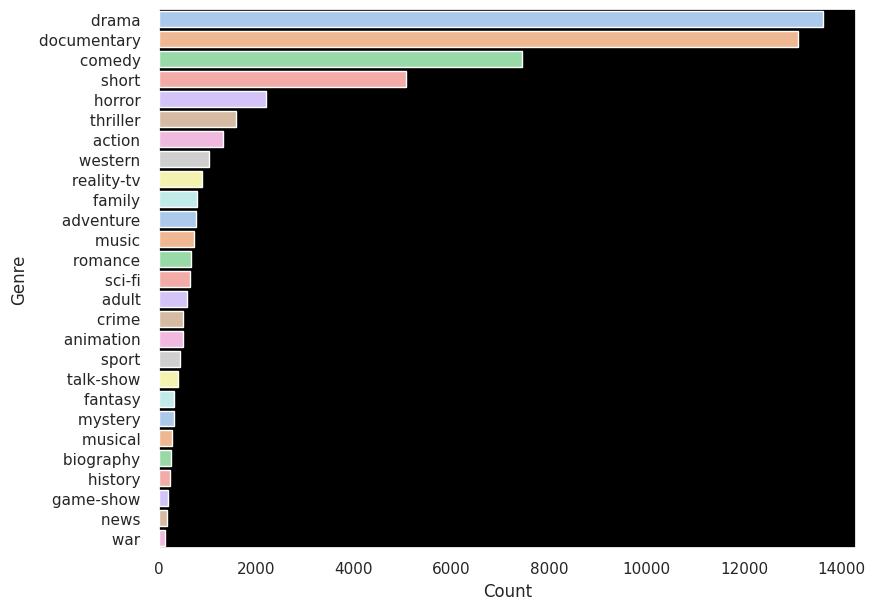

In [ ]:
#count of all the genres
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="dark")
plt.rcParams['axes.facecolor'] = 'black'
genre_counts = train_df['GENRE'].value_counts()
plt.figure(figsize=(9,7))
sns.countplot(y='GENRE', data=train_df, palette='pastel', order=train_df['GENRE'].value_counts().index)
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()

In [ ]:
#TF-IDF Vectorization
vectorize = TfidfVectorizer()

X_train = vectorize.fit_transform(train_df["Description_cleaned"])

X_test = vectorize.transform(test_df["Description_cleaned"])

In [ ]:
X = X_train
y = train_df["GENRE"]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state=42)

In [ ]:
#SVM modeling
linear_model = SVC(kernel='linear')
linear_model.fit(x_train, y_train)
accuracy_linear = linear_model.score(x_test, y_test)
print("Accuracy (Linear Kernel):", accuracy_linear)


Accuracy (Linear Kernel): 0.5902858899477406


In [ ]:
#Logistic Regression Modeling
from sklearn.linear_model import LogisticRegression
lg_model = LogisticRegression()
lg_model.fit(x_train,y_train)
lg_model.score(x_test,y_test)


0.5727636028281586